# Chlorophyll vs Control (Masking CCI's chlorophyll to only show output where there are observations at CCI chlorophyll dataset)
https://www.oceancolour.org/thredds/ncss/grid/CCI_ALL-v5.0-MONTHLY/dataset.html

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality in both SPECTRA and OCCCI throughout the Arctic

In [10]:
occci_inds = sorted(glob.glob('/glade/scratch/gabyn/OCCCI/*.nc', recursive=True))
occci_1998_ds = xr.open_mfdataset(occci_inds[0],combine='by_coords')
occci_1999_ds = xr.open_mfdataset(occci_inds[1],combine='by_coords')
occci_2000_ds = xr.open_mfdataset(occci_inds[2],combine='by_coords')
occci_2001_ds = xr.open_mfdataset(occci_inds[3],combine='by_coords')
occci_2002_ds = xr.open_mfdataset(occci_inds[4],combine='by_coords')
occci_2003_ds = xr.open_mfdataset(occci_inds[5],combine='by_coords')
occci_2004_ds = xr.open_mfdataset(occci_inds[6],combine='by_coords')
occci_2005_ds = xr.open_mfdataset(occci_inds[7],combine='by_coords')
occci_2006_ds = xr.open_mfdataset(occci_inds[8],combine='by_coords')
occci_2007_ds = xr.open_mfdataset(occci_inds[9],combine='by_coords')
occci_2008_ds = xr.open_mfdataset(occci_inds[10],combine='by_coords')
occci_2009_ds = xr.open_mfdataset(occci_inds[11],combine='by_coords')

In [13]:
# Units are in milligram m-3
occci_inter = np.stack([occci_1998_ds.chlor_a,occci_1999_ds.chlor_a,occci_2000_ds.chlor_a,occci_2001_ds.chlor_a,
                          occci_2002_ds.chlor_a,occci_2003_ds.chlor_a,occci_2004_ds.chlor_a,occci_2005_ds.chlor_a,
                          occci_2006_ds.chlor_a,occci_2007_ds.chlor_a,occci_2008_ds.chlor_a,occci_2009_ds.chlor_a]) 
# Here we have year, month, lat, lon 

In [16]:
diat1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_diat1Chl.*.nc', recursive=True))
diat1_1998_ds = xr.open_mfdataset(diat1_inds[8],combine='by_coords')
diat1_1999_ds = xr.open_mfdataset(diat1_inds[9],combine='by_coords')
diat1_2000_ds = xr.open_mfdataset(diat1_inds[10],combine='by_coords')
diat1_2001_ds = xr.open_mfdataset(diat1_inds[11],combine='by_coords')
diat1_2002_ds = xr.open_mfdataset(diat1_inds[12],combine='by_coords')
diat1_2003_ds = xr.open_mfdataset(diat1_inds[13],combine='by_coords')
diat1_2004_ds = xr.open_mfdataset(diat1_inds[14],combine='by_coords')
diat1_2005_ds = xr.open_mfdataset(diat1_inds[15],combine='by_coords')
diat1_2006_ds = xr.open_mfdataset(diat1_inds[16],combine='by_coords')
diat1_2007_ds = xr.open_mfdataset(diat1_inds[17],combine='by_coords')
diat1_2008_ds = xr.open_mfdataset(diat1_inds[18],combine='by_coords')
diat1_2009_ds = xr.open_mfdataset(diat1_inds[19],combine='by_coords')

diat1_ds_inter = np.stack([diat1_1998_ds.diat1Chl,diat1_1999_ds.diat1Chl,diat1_2000_ds.diat1Chl,diat1_2001_ds.diat1Chl,
                          diat1_2002_ds.diat1Chl,diat1_2003_ds.diat1Chl,diat1_2004_ds.diat1Chl,diat1_2005_ds.diat1Chl,
                          diat1_2006_ds.diat1Chl,diat1_2007_ds.diat1Chl,diat1_2008_ds.diat1Chl,diat1_2009_ds.diat1Chl])

In [17]:
diat1_ds_inter.shape

(12, 12, 15, 180, 360)

In [18]:
diat2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_diat2Chl.*.nc', recursive=True))
diat2_1998_ds = xr.open_mfdataset(diat2_inds[8],combine='by_coords')
diat2_1999_ds = xr.open_mfdataset(diat2_inds[9],combine='by_coords')
diat2_2000_ds = xr.open_mfdataset(diat2_inds[10],combine='by_coords')
diat2_2001_ds = xr.open_mfdataset(diat2_inds[11],combine='by_coords')
diat2_2002_ds = xr.open_mfdataset(diat2_inds[12],combine='by_coords')
diat2_2003_ds = xr.open_mfdataset(diat2_inds[13],combine='by_coords')
diat2_2004_ds = xr.open_mfdataset(diat2_inds[14],combine='by_coords')
diat2_2005_ds = xr.open_mfdataset(diat2_inds[15],combine='by_coords')
diat2_2006_ds = xr.open_mfdataset(diat2_inds[16],combine='by_coords')
diat2_2007_ds = xr.open_mfdataset(diat2_inds[17],combine='by_coords')
diat2_2008_ds = xr.open_mfdataset(diat2_inds[18],combine='by_coords')
diat2_2009_ds = xr.open_mfdataset(diat2_inds[19],combine='by_coords')

diat2_ds_inter = np.stack([diat2_1998_ds.diat2Chl,diat2_1999_ds.diat2Chl,diat2_2000_ds.diat2Chl,diat2_2001_ds.diat2Chl,
                          diat2_2002_ds.diat2Chl,diat2_2003_ds.diat2Chl,diat2_2004_ds.diat2Chl,diat2_2005_ds.diat2Chl,
                          diat2_2006_ds.diat2Chl,diat2_2007_ds.diat2Chl,diat2_2008_ds.diat2Chl,diat2_2009_ds.diat2Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/diat2Chl_interannual.npy", diat2_ds_inter)

In [19]:
diat3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_diat3Chl.*.nc', recursive=True))
diat3_1998_ds = xr.open_mfdataset(diat3_inds[8],combine='by_coords')
diat3_1999_ds = xr.open_mfdataset(diat3_inds[9],combine='by_coords')
diat3_2000_ds = xr.open_mfdataset(diat3_inds[10],combine='by_coords')
diat3_2001_ds = xr.open_mfdataset(diat3_inds[11],combine='by_coords')
diat3_2002_ds = xr.open_mfdataset(diat3_inds[12],combine='by_coords')
diat3_2003_ds = xr.open_mfdataset(diat3_inds[13],combine='by_coords')
diat3_2004_ds = xr.open_mfdataset(diat3_inds[14],combine='by_coords')
diat3_2005_ds = xr.open_mfdataset(diat3_inds[15],combine='by_coords')
diat3_2006_ds = xr.open_mfdataset(diat3_inds[16],combine='by_coords')
diat3_2007_ds = xr.open_mfdataset(diat3_inds[17],combine='by_coords')
diat3_2008_ds = xr.open_mfdataset(diat3_inds[18],combine='by_coords')
diat3_2009_ds = xr.open_mfdataset(diat3_inds[19],combine='by_coords')

diat3_ds_inter = np.stack([diat3_1998_ds.diat3Chl,diat3_1999_ds.diat3Chl,diat3_2000_ds.diat3Chl,diat3_2001_ds.diat3Chl,
                          diat3_2002_ds.diat3Chl,diat3_2003_ds.diat3Chl,diat3_2004_ds.diat3Chl,diat3_2005_ds.diat3Chl,
                          diat3_2006_ds.diat3Chl,diat3_2007_ds.diat3Chl,diat3_2008_ds.diat3Chl,diat3_2009_ds.diat3Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/diat3Chl_interannual.npy", diat3_ds_inter)

In [20]:
mp1_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_mp1Chl.*.nc', recursive=True))
mp1_1998_ds = xr.open_mfdataset(mp1_inds[8],combine='by_coords')
mp1_1999_ds = xr.open_mfdataset(mp1_inds[9],combine='by_coords')
mp1_2000_ds = xr.open_mfdataset(mp1_inds[10],combine='by_coords')
mp1_2001_ds = xr.open_mfdataset(mp1_inds[11],combine='by_coords')
mp1_2002_ds = xr.open_mfdataset(mp1_inds[12],combine='by_coords')
mp1_2003_ds = xr.open_mfdataset(mp1_inds[13],combine='by_coords')
mp1_2004_ds = xr.open_mfdataset(mp1_inds[14],combine='by_coords')
mp1_2005_ds = xr.open_mfdataset(mp1_inds[15],combine='by_coords')
mp1_2006_ds = xr.open_mfdataset(mp1_inds[16],combine='by_coords')
mp1_2007_ds = xr.open_mfdataset(mp1_inds[17],combine='by_coords')
mp1_2008_ds = xr.open_mfdataset(mp1_inds[18],combine='by_coords')
mp1_2009_ds = xr.open_mfdataset(mp1_inds[19],combine='by_coords')

mp1_ds_inter = np.stack([mp1_1998_ds.mp1Chl,mp1_1999_ds.mp1Chl,mp1_2000_ds.mp1Chl,mp1_2001_ds.mp1Chl,
                          mp1_2002_ds.mp1Chl,mp1_2003_ds.mp1Chl,mp1_2004_ds.mp1Chl,mp1_2005_ds.mp1Chl,
                          mp1_2006_ds.mp1Chl,mp1_2007_ds.mp1Chl,mp1_2008_ds.mp1Chl,mp1_2009_ds.mp1Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/mp1Chl_interannual.npy", mp1_ds_inter)

In [21]:
mp2_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_mp2Chl.*.nc', recursive=True))
mp2_1998_ds = xr.open_mfdataset(mp2_inds[8],combine='by_coords')
mp2_1999_ds = xr.open_mfdataset(mp2_inds[9],combine='by_coords')
mp2_2000_ds = xr.open_mfdataset(mp2_inds[10],combine='by_coords')
mp2_2001_ds = xr.open_mfdataset(mp2_inds[11],combine='by_coords')
mp2_2002_ds = xr.open_mfdataset(mp2_inds[12],combine='by_coords')
mp2_2003_ds = xr.open_mfdataset(mp2_inds[13],combine='by_coords')
mp2_2004_ds = xr.open_mfdataset(mp2_inds[14],combine='by_coords')
mp2_2005_ds = xr.open_mfdataset(mp2_inds[15],combine='by_coords')
mp2_2006_ds = xr.open_mfdataset(mp2_inds[16],combine='by_coords')
mp2_2007_ds = xr.open_mfdataset(mp2_inds[17],combine='by_coords')
mp2_2008_ds = xr.open_mfdataset(mp2_inds[18],combine='by_coords')
mp2_2009_ds = xr.open_mfdataset(mp2_inds[19],combine='by_coords')

mp2_ds_inter = np.stack([mp2_1998_ds.mp2Chl,mp2_1999_ds.mp2Chl,mp2_2000_ds.mp2Chl,mp2_2001_ds.mp2Chl,
                          mp2_2002_ds.mp2Chl,mp2_2003_ds.mp2Chl,mp2_2004_ds.mp2Chl,mp2_2005_ds.mp2Chl,
                          mp2_2006_ds.mp2Chl,mp2_2007_ds.mp2Chl,mp2_2008_ds.mp2Chl,mp2_2009_ds.mp2Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/mp2Chl_interannual.npy", mp2_ds_inter)

In [22]:
mp3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_mp3Chl.*.nc', recursive=True))
mp3_1998_ds = xr.open_mfdataset(mp3_inds[8],combine='by_coords')
mp3_1999_ds = xr.open_mfdataset(mp3_inds[9],combine='by_coords')
mp3_2000_ds = xr.open_mfdataset(mp3_inds[10],combine='by_coords')
mp3_2001_ds = xr.open_mfdataset(mp3_inds[11],combine='by_coords')
mp3_2002_ds = xr.open_mfdataset(mp3_inds[12],combine='by_coords')
mp3_2003_ds = xr.open_mfdataset(mp3_inds[13],combine='by_coords')
mp3_2004_ds = xr.open_mfdataset(mp3_inds[14],combine='by_coords')
mp3_2005_ds = xr.open_mfdataset(mp3_inds[15],combine='by_coords')
mp3_2006_ds = xr.open_mfdataset(mp3_inds[16],combine='by_coords')
mp3_2007_ds = xr.open_mfdataset(mp3_inds[17],combine='by_coords')
mp3_2008_ds = xr.open_mfdataset(mp3_inds[18],combine='by_coords')
mp3_2009_ds = xr.open_mfdataset(mp3_inds[19],combine='by_coords')

mp3_ds_inter = np.stack([mp3_1998_ds.mp3Chl,mp3_1999_ds.mp3Chl,mp3_2000_ds.mp3Chl,mp3_2001_ds.mp3Chl,
                          mp3_2002_ds.mp3Chl,mp3_2003_ds.mp3Chl,mp3_2004_ds.mp3Chl,mp3_2005_ds.mp3Chl,
                          mp3_2006_ds.mp3Chl,mp3_2007_ds.mp3Chl,mp3_2008_ds.mp3Chl,mp3_2009_ds.mp3Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/mp3Chl_interannual.npy", mp3_ds_inter)

In [23]:
mp4_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_mp4Chl.*.nc', recursive=True))
mp4_1998_ds = xr.open_mfdataset(mp4_inds[8],combine='by_coords')
mp4_1999_ds = xr.open_mfdataset(mp4_inds[9],combine='by_coords')
mp4_2000_ds = xr.open_mfdataset(mp4_inds[10],combine='by_coords')
mp4_2001_ds = xr.open_mfdataset(mp4_inds[11],combine='by_coords')
mp4_2002_ds = xr.open_mfdataset(mp4_inds[12],combine='by_coords')
mp4_2003_ds = xr.open_mfdataset(mp4_inds[13],combine='by_coords')
mp4_2004_ds = xr.open_mfdataset(mp4_inds[14],combine='by_coords')
mp4_2005_ds = xr.open_mfdataset(mp4_inds[15],combine='by_coords')
mp4_2006_ds = xr.open_mfdataset(mp4_inds[16],combine='by_coords')
mp4_2007_ds = xr.open_mfdataset(mp4_inds[17],combine='by_coords')
mp4_2008_ds = xr.open_mfdataset(mp4_inds[18],combine='by_coords')
mp4_2009_ds = xr.open_mfdataset(mp4_inds[19],combine='by_coords')

mp4_ds_inter = np.stack([mp4_1998_ds.mp4Chl,mp4_1999_ds.mp4Chl,mp4_2000_ds.mp4Chl,mp4_2001_ds.mp4Chl,
                          mp4_2002_ds.mp4Chl,mp4_2003_ds.mp4Chl,mp4_2004_ds.mp4Chl,mp4_2005_ds.mp4Chl,
                          mp4_2006_ds.mp4Chl,mp4_2007_ds.mp4Chl,mp4_2008_ds.mp4Chl,mp4_2009_ds.mp4Chl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/mp4Chl_interannual.npy", mp4_ds_inter)

In [24]:
diaz_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_diazChl.*.nc', recursive=True))
diaz_1998_ds = xr.open_mfdataset(diaz_inds[8],combine='by_coords')
diaz_1999_ds = xr.open_mfdataset(diaz_inds[9],combine='by_coords')
diaz_2000_ds = xr.open_mfdataset(diaz_inds[10],combine='by_coords')
diaz_2001_ds = xr.open_mfdataset(diaz_inds[11],combine='by_coords')
diaz_2002_ds = xr.open_mfdataset(diaz_inds[12],combine='by_coords')
diaz_2003_ds = xr.open_mfdataset(diaz_inds[13],combine='by_coords')
diaz_2004_ds = xr.open_mfdataset(diaz_inds[14],combine='by_coords')
diaz_2005_ds = xr.open_mfdataset(diaz_inds[15],combine='by_coords')
diaz_2006_ds = xr.open_mfdataset(diaz_inds[16],combine='by_coords')
diaz_2007_ds = xr.open_mfdataset(diaz_inds[17],combine='by_coords')
diaz_2008_ds = xr.open_mfdataset(diaz_inds[18],combine='by_coords')
diaz_2009_ds = xr.open_mfdataset(diaz_inds[19],combine='by_coords')

diaz_ds_inter = np.stack([diaz_1998_ds.diazChl,diaz_1999_ds.diazChl,diaz_2000_ds.diazChl,diaz_2001_ds.diazChl,
                          diaz_2002_ds.diazChl,diaz_2003_ds.diazChl,diaz_2004_ds.diazChl,diaz_2005_ds.diazChl,
                          diaz_2006_ds.diazChl,diaz_2007_ds.diazChl,diaz_2008_ds.diazChl,diaz_2009_ds.diazChl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/diazChl_interannual.npy", diaz_ds_inter)

In [25]:
pp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/regrid_SPECTRA_ppChl.*.nc', recursive=True))
pp_1998_ds = xr.open_mfdataset(pp_inds[8],combine='by_coords')
pp_1999_ds = xr.open_mfdataset(pp_inds[9],combine='by_coords')
pp_2000_ds = xr.open_mfdataset(pp_inds[10],combine='by_coords')
pp_2001_ds = xr.open_mfdataset(pp_inds[11],combine='by_coords')
pp_2002_ds = xr.open_mfdataset(pp_inds[12],combine='by_coords')
pp_2003_ds = xr.open_mfdataset(pp_inds[13],combine='by_coords')
pp_2004_ds = xr.open_mfdataset(pp_inds[14],combine='by_coords')
pp_2005_ds = xr.open_mfdataset(pp_inds[15],combine='by_coords')
pp_2006_ds = xr.open_mfdataset(pp_inds[16],combine='by_coords')
pp_2007_ds = xr.open_mfdataset(pp_inds[17],combine='by_coords')
pp_2008_ds = xr.open_mfdataset(pp_inds[18],combine='by_coords')
pp_2009_ds = xr.open_mfdataset(pp_inds[19],combine='by_coords')

pp_ds_inter = np.stack([pp_1998_ds.ppChl,pp_1999_ds.ppChl,pp_2000_ds.ppChl,pp_2001_ds.ppChl,
                          pp_2002_ds.ppChl,pp_2003_ds.ppChl,pp_2004_ds.ppChl,pp_2005_ds.ppChl,
                          pp_2006_ds.ppChl,pp_2007_ds.ppChl,pp_2008_ds.ppChl,pp_2009_ds.ppChl])

#np.save("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_4/Interannual_variability_data/ppChl_interannual.npy", pp_ds_inter)

In [26]:
phytoChl = np.stack([pp_ds_inter, mp1_ds_inter, diaz_ds_inter, 
                               diat1_ds_inter, mp2_ds_inter, diat2_ds_inter, 
                               mp3_ds_inter, diat3_ds_inter, mp4_ds_inter])

In [27]:
phytoChl.shape

(9, 12, 12, 15, 180, 360)

In [33]:
# Depth integrated top 50 m 
phytoChl_50m = np.nansum(phytoChl[:,:,:,0:5,:,:], axis =(0,3))*10/50 

# Surface Chl. 
phytoChl_surface = np.nansum(phytoChl[:,:,:,0,:,:], axis =0) 

In [28]:
ind_data_01 = np.isnan(occci_inter[:,0,:,:])
ind_data_02 = np.isnan(occci_inter[:,1,:,:])
ind_data_03 = np.isnan(occci_inter[:,2,:,:])
ind_data_04 = np.isnan(occci_inter[:,3,:,:])
ind_data_05 = np.isnan(occci_inter[:,4,:,:])
ind_data_06 = np.isnan(occci_inter[:,5,:,:])
ind_data_07 = np.isnan(occci_inter[:,6,:,:])
ind_data_08 = np.isnan(occci_inter[:,7,:,:])
ind_data_09 = np.isnan(occci_inter[:,8,:,:])
ind_data_10 = np.isnan(occci_inter[:,9,:,:])
ind_data_11 = np.isnan(occci_inter[:,10,:,:])
ind_data_12 = np.isnan(occci_inter[:,11,:,:])

In [34]:
phytoChl_50m.shape

(12, 12, 180, 360)

In [35]:
# this makes the values that are NaN on the obs to NaN in SPECTRA
phytoChl_50m[0,ind_data_01] = np.nan 
phytoChl_50m[1,ind_data_02] = np.nan
phytoChl_50m[2,ind_data_03] = np.nan
phytoChl_50m[3,ind_data_04] = np.nan
phytoChl_50m[4,ind_data_05] = np.nan
phytoChl_50m[5,ind_data_06] = np.nan
phytoChl_50m[6,ind_data_07] = np.nan
phytoChl_50m[7,ind_data_08] = np.nan
phytoChl_50m[8,ind_data_09] = np.nan
phytoChl_50m[9,ind_data_10] = np.nan
phytoChl_50m[10,ind_data_11] = np.nan
phytoChl_50m[11,ind_data_12] = np.nan

# NOW FOR THE SURFACE
phytoChl_surface[0,ind_data_01] = np.nan 
phytoChl_surface[1,ind_data_02] = np.nan
phytoChl_surface[2,ind_data_03] = np.nan
phytoChl_surface[3,ind_data_04] = np.nan
phytoChl_surface[4,ind_data_05] = np.nan
phytoChl_surface[5,ind_data_06] = np.nan
phytoChl_surface[6,ind_data_07] = np.nan
phytoChl_surface[7,ind_data_08] = np.nan
phytoChl_surface[8,ind_data_09] = np.nan
phytoChl_surface[9,ind_data_10] = np.nan
phytoChl_surface[10,ind_data_11] = np.nan
phytoChl_surface[11,ind_data_12] = np.nan

In [41]:
# Model Chlorophyll for every region (surface)
model_ao = np.nanmean(phytoChl_surface[:,:,170:180,:], axis=(0,2,3))
model_cs = np.nanmean(phytoChl_surface[:,:,149:170,0:25], axis=(0,2,3))
model_bs = np.nanmean(phytoChl_surface[:,:,149:170,25:55], axis=(0,2,3))
model_ca = np.nanmean(phytoChl_surface[:,:,149:170,55:110], axis=(0,2,3))
model_bb = np.nanmean(phytoChl_surface[:,:,149:170,110:135], axis=(0,2,3))
model_ess = np.nanmean(phytoChl_surface[:,:,149:170,325:360], axis=(0,2,3))
model_ls = np.nanmean(phytoChl_surface[:,:,149:170,270:325], axis=(0,2,3))
model_ns = np.nanmean(phytoChl_surface[:,:,149:170,155:205], axis=(0,2,3))
model_bts =np.nanmean(phytoChl_surface[:,:,149:170,205:233], axis=(0,2,3))
model_ks = np.nanmean(phytoChl_surface[:,:,149:170,233:270], axis=(0,2,3))

# Top 50 meters
model_ao_50m = np.nanmean(phytoChl_50m[:,:,170:180,:], axis=(0,2,3))
model_cs_50m = np.nanmean(phytoChl_50m[:,:,149:170,0:25], axis=(0,2,3))
model_bs_50m = np.nanmean(phytoChl_50m[:,:,149:170,25:55], axis=(0,2,3))
model_ca_50m = np.nanmean(phytoChl_50m[:,:,149:170,55:110], axis=(0,2,3))
model_bb_50m = np.nanmean(phytoChl_50m[:,:,149:170,110:135], axis=(0,2,3))
model_ess_50m = np.nanmean(phytoChl_50m[:,:,149:170,325:360], axis=(0,2,3))
model_ls_50m = np.nanmean(phytoChl_50m[:,:,149:170,270:325], axis=(0,2,3))
model_ns_50m = np.nanmean(phytoChl_50m[:,:,149:170,155:205], axis=(0,2,3))
model_bts_50m =np.nanmean(phytoChl_50m[:,:,149:170,205:233], axis=(0,2,3))
model_ks_50m = np.nanmean(phytoChl_50m[:,:,149:170,233:270], axis=(0,2,3))

# Observed Chlorophyll for every region. 

obs_ao = np.nanmean(occci_inter[:,:,170:180,:], axis=(0,2,3))
obs_cs = np.nanmean(occci_inter[:,:,149:170,0:25], axis=(0,2,3))
obs_bs = np.nanmean(occci_inter[:,:,149:170,25:55], axis=(0,2,3))
obs_ca = np.nanmean(occci_inter[:,:,149:170,55:110], axis=(0,2,3))
obs_bb = np.nanmean(occci_inter[:,:,149:170,110:135], axis=(0,2,3))
obs_ess = np.nanmean(occci_inter[:,:,149:170,325:360], axis=(0,2,3))
obs_ls = np.nanmean(occci_inter[:,:,149:170,270:325], axis=(0,2,3))
obs_ns = np.nanmean(occci_inter[:,:,149:170,155:205], axis=(0,2,3))
obs_bts =np.nanmean(occci_inter[:,:,149:170,205:233], axis=(0,2,3))
obs_ks = np.nanmean(occci_inter[:,:,149:170,233:270], axis=(0,2,3))

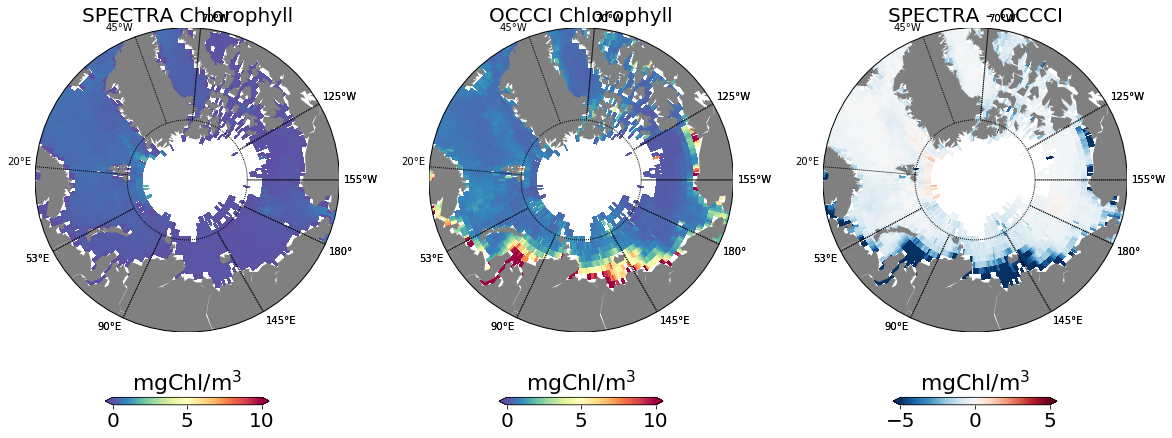

In [43]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_surface, axis=(0,1)), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(occci_inter, axis=(0,1)), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',vmin=0,vmax=10);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('OCCCI Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(chl-chlo),cmap='RdBu_r', vmin = -5, vmax = 5);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('SPECTRA - OCCCI', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_OCCCI_comparison.png',dpi=600, bbox_inches='tight')

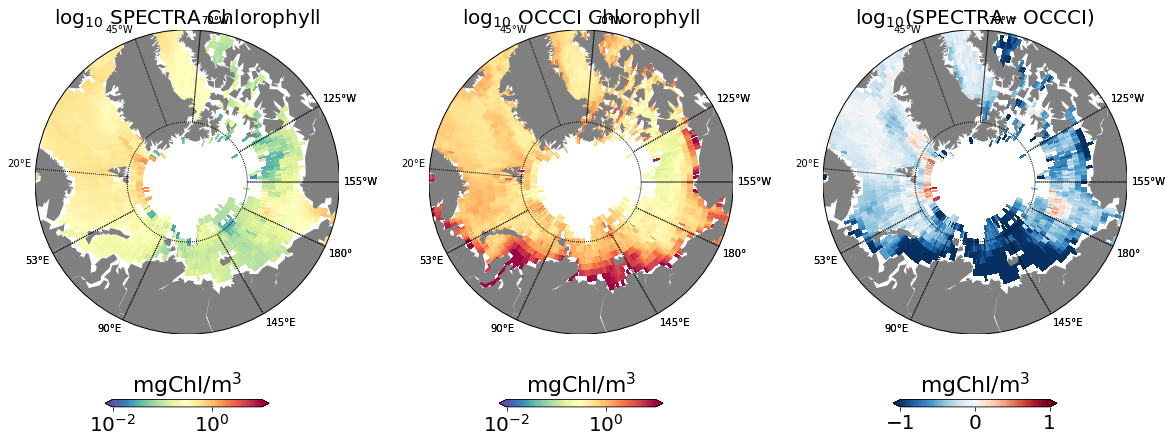

In [44]:
fig = plt.figure(figsize=(20, 8));

ax = fig.add_subplot(1, 3, 1);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chl, lon = add_cyclic_point(np.nanmean(phytoChl_surface, axis=(0,1)), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chl,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('log$_{10}$ SPECTRA Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 2);
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');

chlo, lon = add_cyclic_point(np.nanmean(occci_inter, axis=(0,1)), coord=obss.lon, axis=1);
x, y = m(*np.meshgrid(lon,obss.lat));
cf = m.pcolor(x,y,chlo,cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('log$_{10}$ OCCCI Chlorophyll', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);

ax = fig.add_subplot(1, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c');
m.fillcontinents(color='gray');
cf = m.pcolor(x,y,(np.log10(chl)-np.log10(chlo)),cmap='RdBu_r', vmin = -1, vmax = 1);
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal',extend = 'both');
cb.ax.set_title('$mg Chl$/$m^3$', fontsize = 22);
cb.ax.tick_params(labelsize=20);
ax.set_title('log$_{10}$(SPECTRA - OCCCI)', fontsize =20);

m.drawmeridians((180,205), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((205,235), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((235,290), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((290,315), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((145,180), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((90,145), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((53,90), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawmeridians((20,53), color='k', textcolor='k', linewidth=1.0, 
              zorder=None, dashes=[1, 1], labels=[1, 1, 1, 1])
m.drawparallels((60,90), color='k', textcolor='k', 
                linewidth=1.0, zorder=None, dashes=[1, 1], 
                labels=[0, 0, 0, 0]);
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chla_AO_OCCCI_log10.png',dpi=600, bbox_inches='tight')

In [45]:
# This is the error on the observations
err_ao = np.nanstd(obs_ao)
err_cs = np.nanstd(obs_cs)
err_bs = np.nanstd(obs_bs)
err_ca = np.nanstd(obs_ca)
err_bb = np.nanstd(obs_bb)
err_ess = np.nanstd(obs_ess)
err_ls = np.nanstd(obs_ls)
err_ns = np.nanstd(obs_ns)
err_bts = np.nanstd(obs_bts)
err_ks = np.nanstd(obs_ks)

# This is the error on the model
err_aom = np.nanstd(model_ao)
err_csm = np.nanstd(model_cs)
err_bsm = np.nanstd(model_bs)
err_cam = np.nanstd(model_ca)
err_bbm = np.nanstd(model_bb)
err_essm = np.nanstd(model_ess)
err_lsm = np.nanstd(model_ls)
err_nsm = np.nanstd(model_ns)
err_btsm = np.nanstd(model_bts)
err_ksm = np.nanstd(model_ks)

In [46]:
err_aom

0.40310055

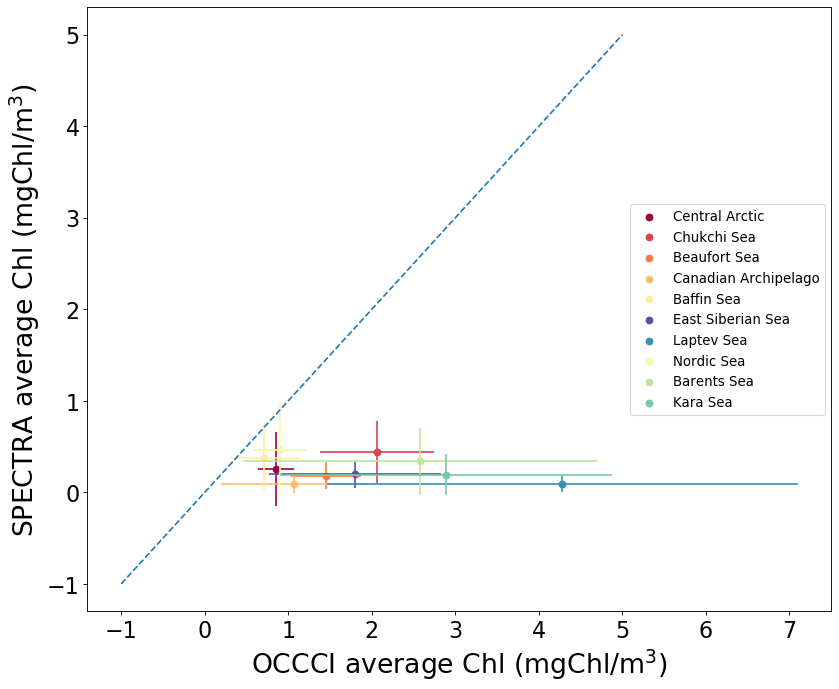

In [47]:
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

cmap=matplotlib.cm.get_cmap('Spectral', 10)

plt.scatter(np.nanmean(obs_ao),np.nanmean(model_ao),color=cmap(0),label='Central Arctic')
plt.errorbar(np.nanmean(obs_ao),np.nanmean(model_ao),yerr=err_aom,xerr=err_ao, color=cmap(0),linestyle="None")

plt.scatter(np.nanmean(obs_cs),np.nanmean(model_cs),color=cmap(1),label='Chukchi Sea')
plt.errorbar(np.nanmean(obs_cs),np.nanmean(model_cs),yerr=err_csm,xerr=err_cs, color=cmap(1),linestyle="None")

plt.scatter(np.nanmean(obs_bs),np.nanmean(model_bs), color=cmap(2),label='Beaufort Sea')
plt.errorbar(np.nanmean(obs_bs),np.nanmean(model_bs),yerr=err_bsm,xerr=err_bs, color=cmap(2),linestyle="None")

plt.scatter(np.nanmean(obs_ca),np.nanmean(model_ca), color=cmap(3),label='Canadian Archipelago')
plt.errorbar(np.nanmean(obs_ca),np.nanmean(model_ca),yerr=err_cam,xerr=err_ca, color=cmap(3),linestyle="None")

plt.scatter(np.nanmean(obs_bb),np.nanmean(model_bb), color=cmap(4),label='Baffin Sea')
plt.errorbar(np.nanmean(obs_bb),np.nanmean(model_bb),yerr=err_bbm,xerr=err_bb, color=cmap(4),linestyle="None")

plt.scatter(np.nanmean(obs_ess),np.nanmean(model_ess), color=cmap(9),label='East Siberian Sea')
plt.errorbar(np.nanmean(obs_ess),np.nanmean(model_ess),yerr=err_essm,xerr=err_ess, color=cmap(9),linestyle="None")

plt.scatter(np.nanmean(obs_ls),np.nanmean(model_ls),color=cmap(8),label='Laptev Sea')
plt.errorbar(np.nanmean(obs_ls),np.nanmean(model_ls),yerr=err_lsm,xerr=err_ls, color=cmap(8),linestyle="None")

plt.scatter(np.nanmean(obs_ns),np.nanmean(model_ns), color=cmap(5),label='Nordic Sea')
plt.errorbar(np.nanmean(obs_ns),np.nanmean(model_ns),yerr=err_nsm,xerr=err_ns, color=cmap(5),linestyle="None")

plt.scatter(np.nanmean(obs_bts),np.nanmean(model_bts), color=cmap(6),label='Barents Sea')
plt.errorbar(np.nanmean(obs_bts),np.nanmean(model_bts),yerr=err_btsm,xerr=err_bts, color=cmap(6),linestyle="None")

plt.scatter(np.nanmean(obs_ks),np.nanmean(model_ks), color=cmap(7),label='Kara Sea')
plt.errorbar(np.nanmean(obs_ks),np.nanmean(model_ks),yerr=err_ksm,xerr=err_ks, color=cmap(7),linestyle="None")

plt.plot([-1,0,1,2,3,4,5], [-1,0,1,2,3,4,5], '--')

plt.legend(loc='center right', fontsize=12)
plt.ylabel('SPECTRA average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.xlabel('OCCCI average Chl ($mg Chl$/$m^3$)', fontsize=24)
plt.yticks(fontsize=20);plt.xticks(fontsize=20)

plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_scatter_remap_.png', dpi=600, bbox_inches='tight')

## Now check the seasonality

In [48]:
PAR_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_PAR_avg.*.nc', recursive=True))
PAR_ds = xr.open_mfdataset(PAR_inds,combine='by_coords')

ice_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim_remap/regrid_GNG595_ECOSYS_IFRAC.*.nc', recursive=True))
ice_ds = xr.open_mfdataset(ice_inds,combine='by_coords')

In [49]:
# Model ice for every region 
ice_ao = np.nanmean(ice_ds.ECOSYS_IFRAC[:,170:180,:], axis=(1,2))
ice_cs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,0:25], axis = (1,2))
ice_bs = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,25:55], axis = (1,2))
ice_ca = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,55:110], axis = (1,2))
ice_bb = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,110:135], axis = (1,2))
ice_ess = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,325:360], axis = (1,2))
ice_ls = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,270:325], axis = (1,2))
ice_ns = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,155:205], axis = (1,2))
ice_bts =np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,205:233], axis = (1,2))
ice_ks = np.nanmean(ice_ds.ECOSYS_IFRAC[:,149:170,233:270], axis = (1,2))


# Modeling the PAR average 
PAR_ao = np.nanmean(PAR_ds.PAR_avg[:,0,170:180,:], axis=(1,2))
PAR_cs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,0:25], axis = (1,2))
PAR_bs = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,25:55], axis = (1,2))
PAR_ca = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,55:110], axis = (1,2))
PAR_bb = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,110:135], axis = (1,2))
PAR_ess = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,325:360], axis = (1,2))
PAR_ls = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,270:325], axis = (1,2))
PAR_ns = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,155:205], axis = (1,2))
PAR_bts =np.nanmean(PAR_ds.PAR_avg[:,0,149:170,205:233], axis = (1,2))
PAR_ks = np.nanmean(PAR_ds.PAR_avg[:,0,149:170,233:270], axis = (1,2))

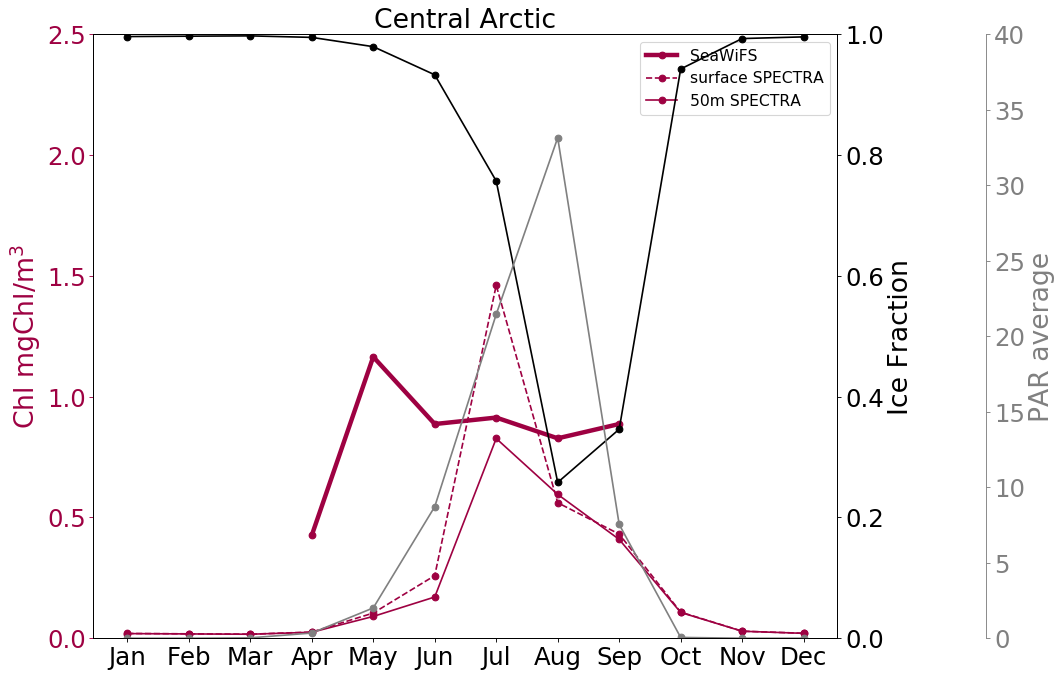

In [51]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ao, '-o', color=cmap(0),linewidth=4,label='SeaWiFS')
ax.plot(months,model_ao, '--o', color=cmap(0),label='surface SPECTRA')
ax.plot(months,model_ao_50m, '-o', color=cmap(0),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Central Arctic', fontsize=24)

ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ao,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ao,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,40)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(0))  
ax.spines['left'].set_color(cmap(0)); ax.tick_params(axis='y', colors=cmap(0))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_CentralArctic_seasonality_remap.png', dpi=600, bbox_inches='tight')

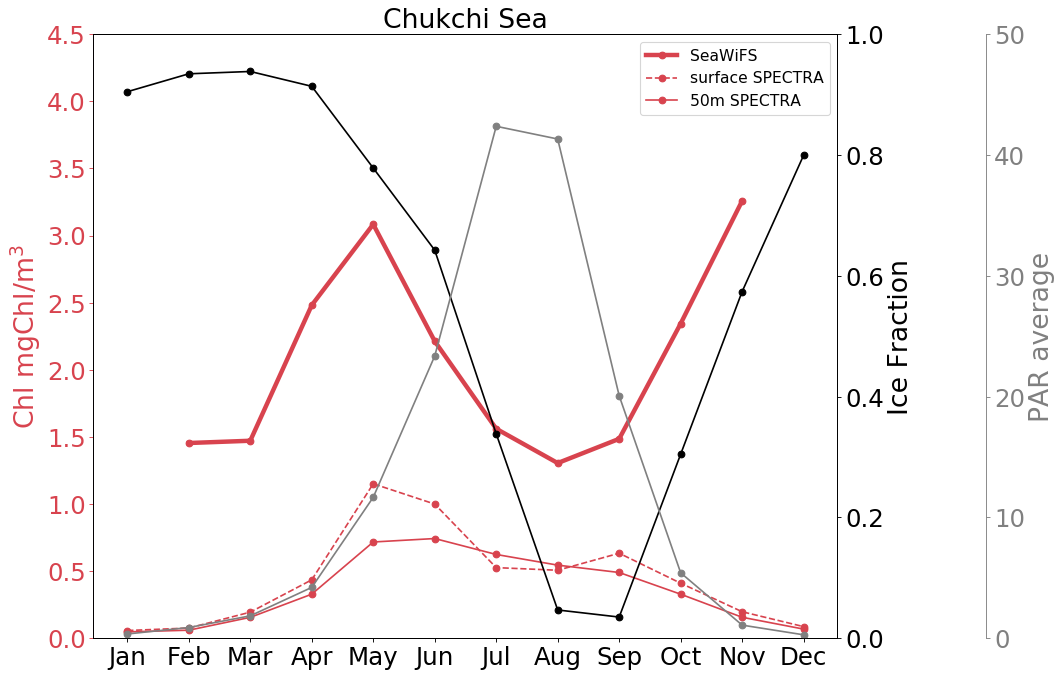

In [52]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_cs, '-o', color=cmap(1),linewidth = 4, label='SeaWiFS')
ax.plot(months,model_cs, '--o', color=cmap(1),label='surface SPECTRA')
ax.plot(months,model_cs_50m, '-o', color=cmap(1),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Chukchi Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_cs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_cs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(1))  
ax.spines['left'].set_color(cmap(1)); ax.tick_params(axis='y', colors=cmap(1))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Chukchi_seasonality_remap.png', dpi=600, bbox_inches='tight')

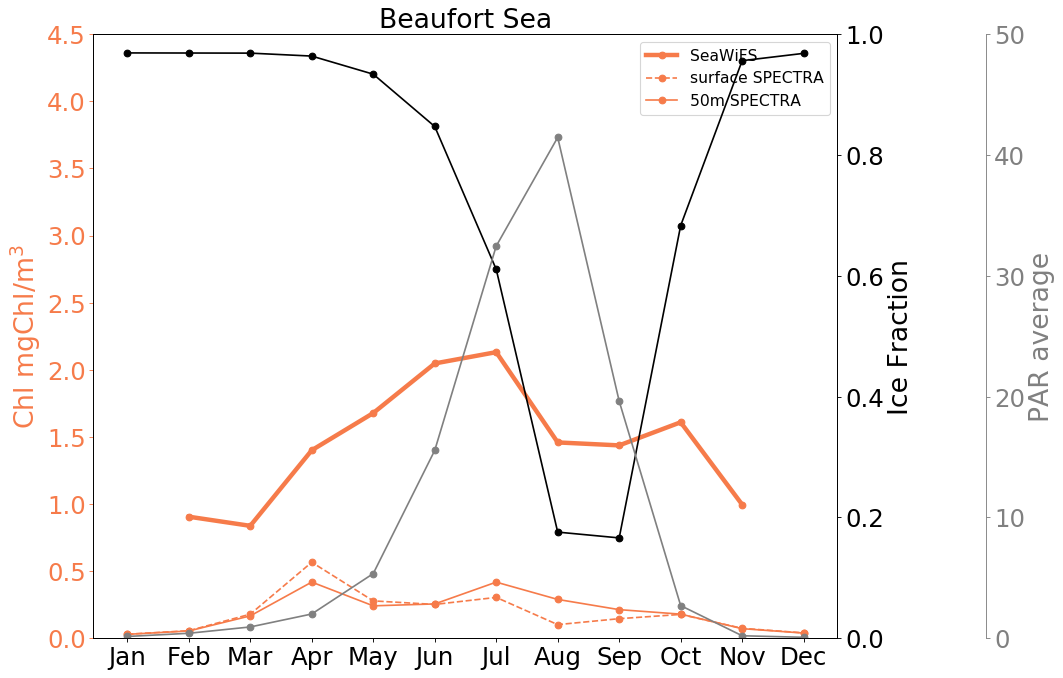

In [53]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bs, '-o', color=cmap(2),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bs, '--o', color=cmap(2),label='surface SPECTRA')
ax.plot(months,model_bs_50m, '-o', color=cmap(2),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Beaufort Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bs,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bs,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5, 3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(2))  
ax.spines['left'].set_color(cmap(2)); ax.tick_params(axis='y', colors=cmap(2))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Beaufort_seasonality_remap.png', dpi=600, bbox_inches='tight')

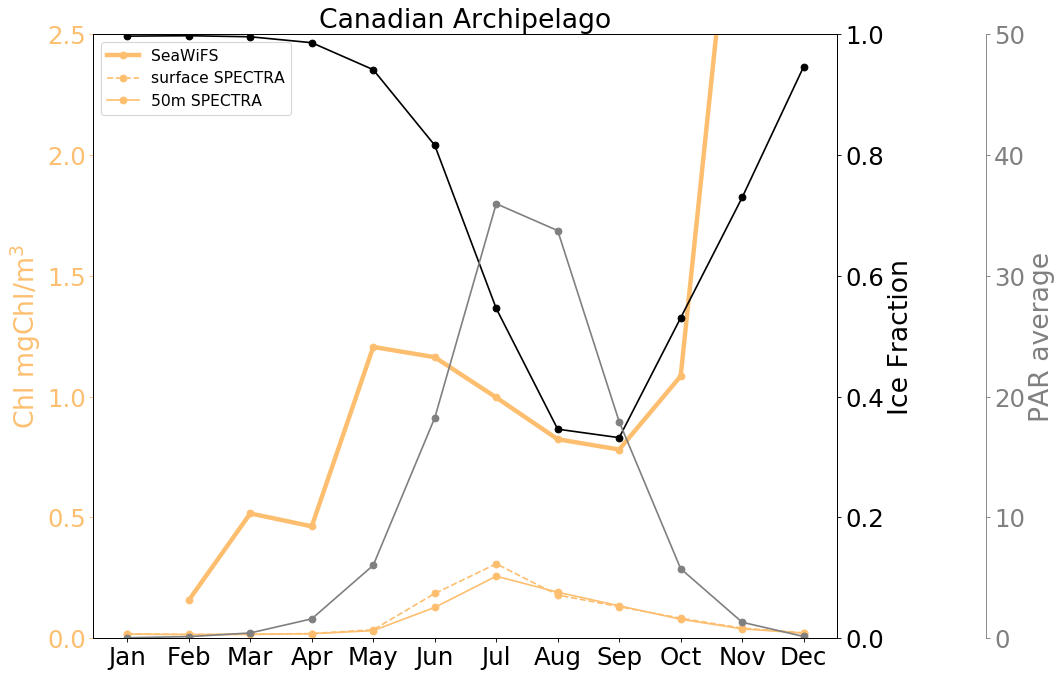

In [54]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ca, '-o', color=cmap(3),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ca, '--o', color=cmap(3),label='surface SPECTRA')
ax.plot(months,model_ca_50m, '-o', color=cmap(3),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Canadian Archipelago', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ca,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ca,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,50)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(3))  
ax.spines['left'].set_color(cmap(3)); ax.tick_params(axis='y', colors=cmap(3))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Canadian_seasonality_remap.png', dpi=600, bbox_inches='tight')

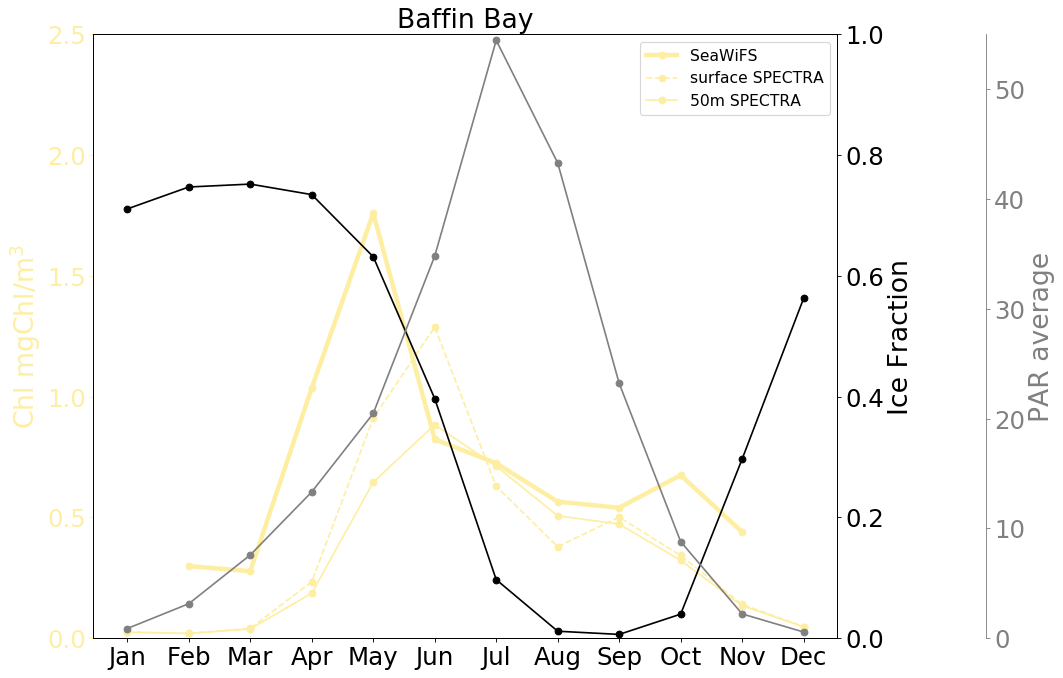

In [55]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bb, '-o', color=cmap(4),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bb, '--o', color=cmap(4),label='surface SPECTRA')
ax.plot(months,model_bb_50m, '-o', color=cmap(4),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Baffin Bay', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bb,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bb,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(4))  
ax.spines['left'].set_color(cmap(4)); ax.tick_params(axis='y', colors=cmap(4))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Baffin_seasonality_remap.png', dpi=600, bbox_inches='tight')

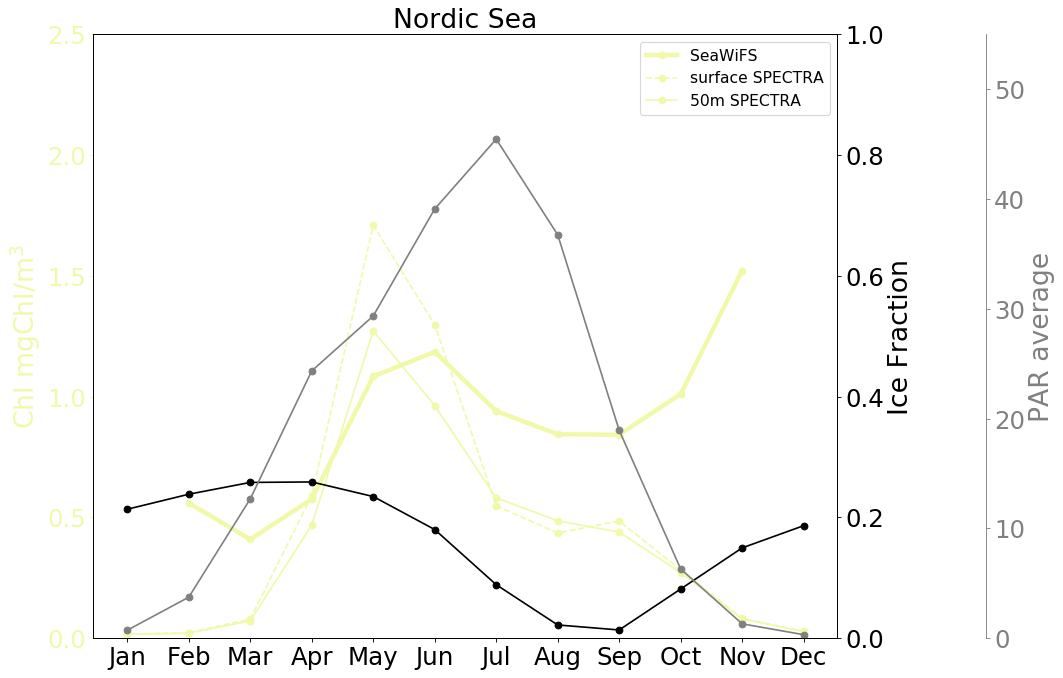

In [56]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ns, '-o', color=cmap(5),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ns, '--o', color=cmap(5),label='surface SPECTRA')
ax.plot(months,model_ns_50m, '-o', color=cmap(5),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Nordic Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ns,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ns,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,2.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(5))  
ax.spines['left'].set_color(cmap(5)); ax.tick_params(axis='y', colors=cmap(5))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Nordic_seasonality_remap.png', dpi=600, bbox_inches='tight')

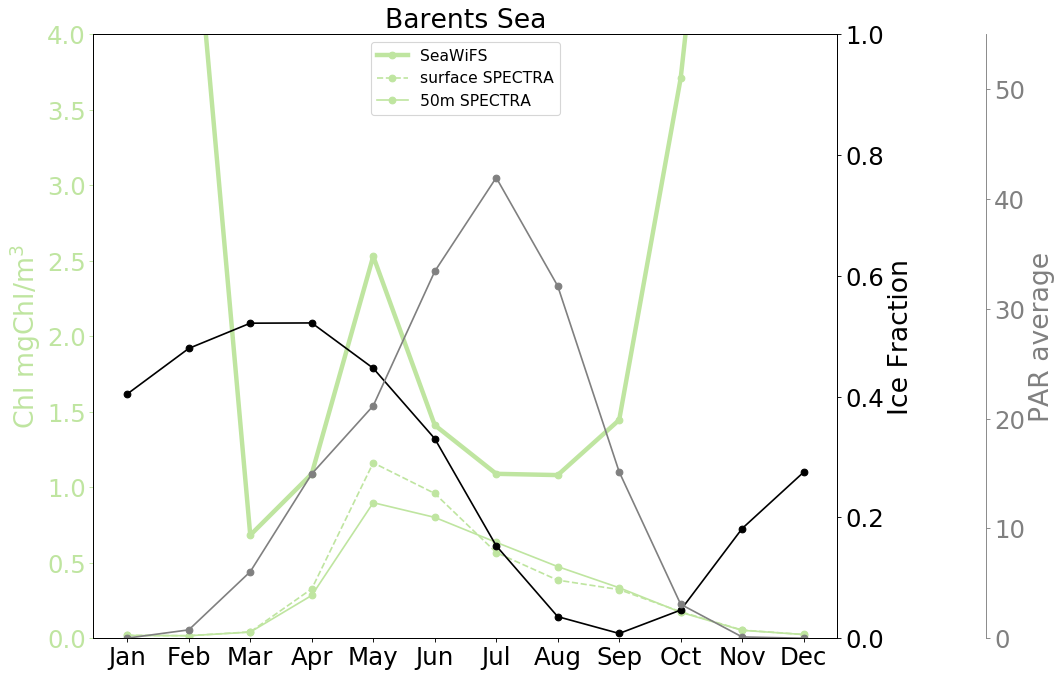

In [57]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_bts, '-o', color=cmap(6),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_bts, '--o', color=cmap(6),label='surface SPECTRA')
ax.plot(months,model_bts_50m, '-o', color=cmap(6),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Barents Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_bts,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_bts,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(6))  
ax.spines['left'].set_color(cmap(6)); ax.tick_params(axis='y', colors=cmap(6))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Barents_seasonality_remap.png', dpi=600, bbox_inches='tight')

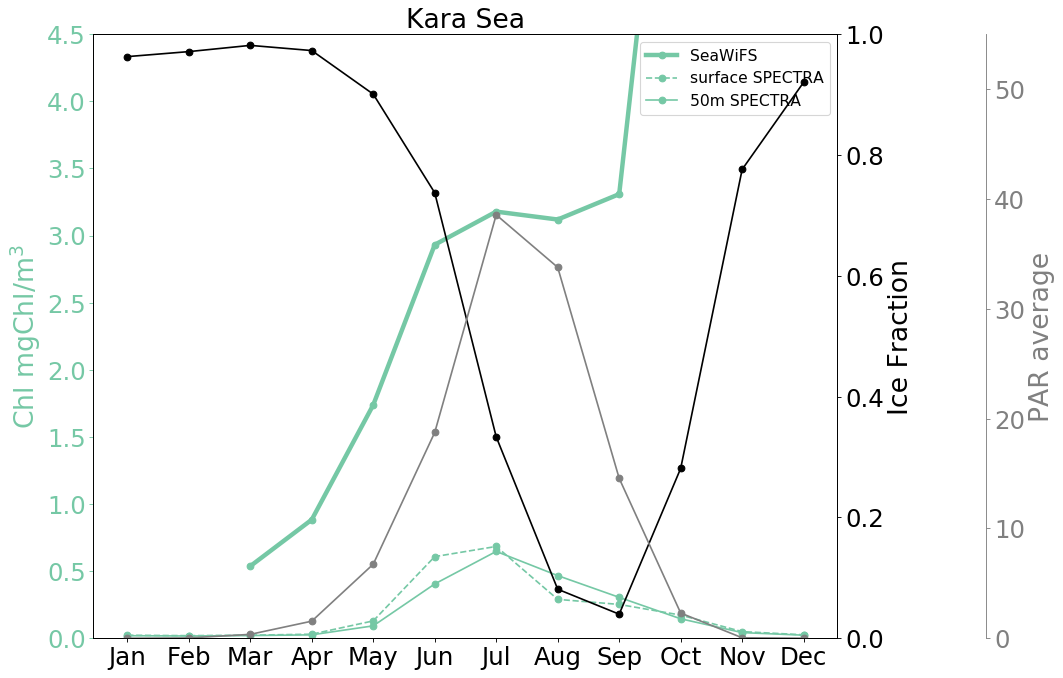

In [58]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ks, '-o', color=cmap(7),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ks, '--o', color=cmap(7),label='surface SPECTRA')
ax.plot(months,model_ks_50m, '-o', color=cmap(7),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Kara Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ks,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ks,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,4.5); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(7))  
ax.spines['left'].set_color(cmap(7)); ax.tick_params(axis='y', colors=cmap(7))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)

fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Kara_seasonality_remap.png', dpi=600, bbox_inches='tight')

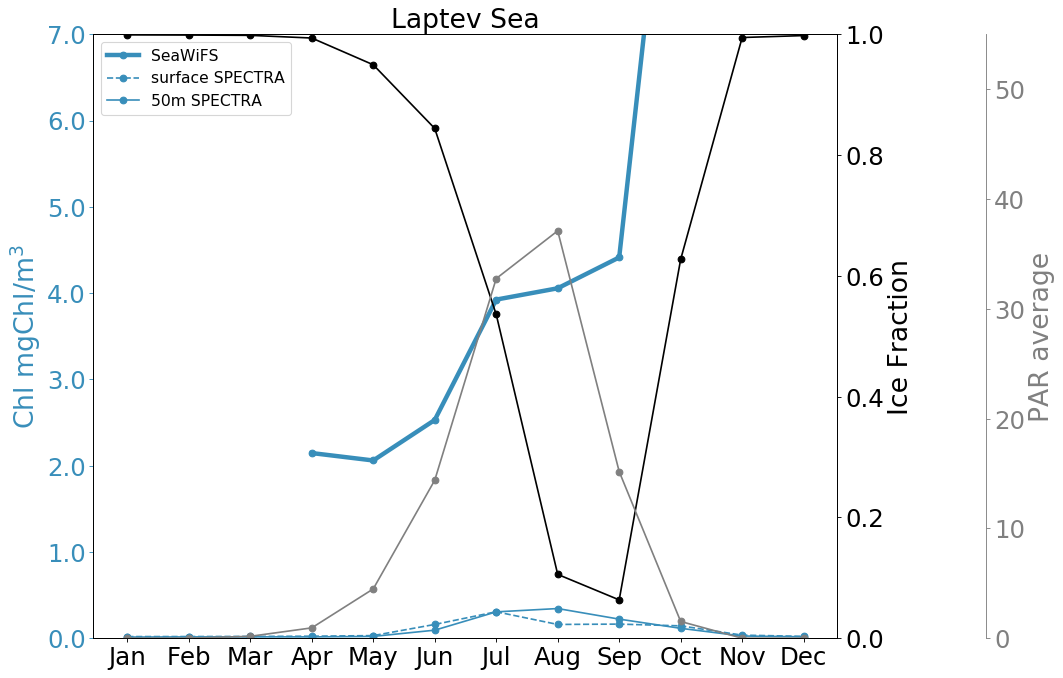

In [59]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)

months = ('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec')

fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax.plot(months,obs_ls, '-o', color=cmap(8),linewidth = 4,label='SeaWiFS')
ax.plot(months,model_ls, '--o', color=cmap(8),label='surface SPECTRA')
ax.plot(months,model_ls_50m, '-o', color=cmap(8),label='50m SPECTRA')

ax.legend(loc='lower right')
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24)
ax.set_title('Laptev Sea', fontsize=24)
ax2 = ax.twinx()
ax3 = ax.twinx(); ax3.spines['right'].set_position(("axes", 1.2))
ax2.plot(months, ice_ls,'-o', color='k',label='Ice-Fraction')
ax3.plot(months, PAR_ls,'-o', color='gray',label='PAR Average')

ax.set_ylim(0,7.0); ax2.set_ylim(0,1); ax3.set_ylim(0,55)
ax.set_yticklabels([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0],fontsize=22)
ax2.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=22)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=22)
ax.legend(loc='top right', fontsize=14)
# Axes for chlorophyll 
ax.set_ylabel('Chl $mg Chl$/$m^3$', fontsize=24); ax.yaxis.label.set_color(cmap(8))  
ax.spines['left'].set_color(cmap(8)); ax.tick_params(axis='y', colors=cmap(8))  
# Axes for Ice Fraction  
ax2.set_ylabel('Ice Fraction', fontsize=24);ax2.yaxis.label.set_color('k')  
ax2.spines['right'].set_color('k'); ax2.tick_params(axis='y', colors='k')  
# Axes for PAR average
ax3.set_ylabel('PAR average', fontsize=24);ax3.yaxis.label.set_color('gray')  
ax3.spines['right'].set_color('gray'); ax3.tick_params(axis='y', colors='gray')  
plt.yticks(fontsize=22);plt.xticks(fontsize=22)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_SPECTRA_OCCCI_Laptev_seasonality_remap.png', dpi=600, bbox_inches='tight')